In [38]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError

from sklearn.metrics import r2_score, mean_squared_error



In [39]:
def scale_datasets(x_train, x_test):

  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled
print(tf.config.list_physical_devices('GPU'))

[]


In [40]:
learning_rate = 0.01

In [41]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()

In [42]:
import pandas as pd

# Creating an empty DataFrame with the desired columns
# r2_df = pd.DataFrame({'seed': [], 'hu': [], 'train': [], 'val': [], 'test': []})
r2_df = pd.DataFrame([], columns=['seed', 'hu', 'train', 'val','test'], dtype=int)



# r2_df = r2_df.astype({'seed': int, 'hu': int})




r2_df.set_index(['seed', 'hu'], inplace=True)

new_row = pd.Series({'train': 1, 'val': 2, 'test': 3}, name=(1, 2))
# r2_df.index = r2_df.index.map(lambda x: (int(x[0]), int(x[1])))

# Convert index values to integers


print(r2_df)

Empty DataFrame
Columns: [train, val, test]
Index: []


In [43]:
# x_train = features, y_train = target

df = pd.read_csv('13-iri-cleaned.csv')



x = df.drop(['RoadRoidIRI'],axis=1)
y = df.RoadRoidIRI

import numpy as np
import os
import random
import tensorflow as tf

evaluation = []
histories = []
# Seed value
# Apparently you may use different seed values at each stage
for initial_seed in [  4,   6,  11,  12,  14,  15,  23,  24,  25,  29,  30,  36,  38,  46, 47,  48,  56,  59,  67,  71,  72,  73,  80,  92,  99, 104, 105, 106, 112, 115, 120, 121, 122, 128, 130, 132, 143, 144, 147, 153, 156, 157, 160, 163, 164, 173, 175, 177, 178, 179, 181, 184, 189, 193, 196, 198]:
    seed_value= initial_seed

    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)
    # for later versions: 
    # tf.compat.v1.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    # import keras.backend.tensorflow_backend as K
    # session_conf =  tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    # K.set_session(sess)
    # for later versions:
    # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    # tf.compat.v1.keras.backend.set_session(sess)


    # from keras import backend as K
    # K.tensorflow_backend.set_session(sess)
    # import tensorflow.keras.backend as K
    # K.set_session(sess)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=seed_value)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8889, random_state=seed_value)


    x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)
    _ , x_val_scaled = scale_datasets(x_train, x_val)


    # model = build_model_using_sequential()
    for hu in [6, 9, 13, 20]:
        model = Sequential([
            Dense(hu, kernel_initializer='normal', activation='relu'),
            # Dropout(0.2),
            # Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
            # Dropout(0.2),
            # Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
            Dense(1, kernel_initializer='normal', activation='relu')
        ])

        # loss function
        msle = MeanSquaredLogarithmicError()
        mse = MeanSquaredError()
        
        model.compile(
        loss=mse, 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=['mse' ]
    )
        # train the model
        history = model.fit(
            x_train_scaled.values, 
            y_train.values, 
            epochs=60, 
            batch_size=32,
            # validation_split=0.1,
            validation_data=(x_val_scaled.values, y_val.values),
            verbose=0
        )

        # plot_history(history, 'mse')
        histories.append(history)


        test_mse = model.evaluate(x_test_scaled.values,y_test.values)[0]

        test_r2 = 1 - test_mse / np.var(y)
        train_r2 = 1 - (history.history['mse'][-1]) / np.var(y)
        validation_r2 = 1 - (history.history['val_mse'][-1] / np.var(y))

        r2_df.loc[(initial_seed, hu), :] = [train_r2, validation_r2, test_r2]
        evaluation.append([hu, test_r2, train_r2, validation_r2])
        
        # print(f"test_r2 = {test_r2}")
        # print(f"train_r2 = {train_r2}")
        # print(f"validation_r2 = {validation_r2}")
r2_df.to_csv("eval4.csv")




2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1338 - mse: 1.2002 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2144 - mse: 1.2742 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0168 - mse: 1.0693 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2127 - mse: 1.2584 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9058 - mse: 0.8335 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9692 - mse: 0.8988 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9493 - mse: 0.8908 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1446 - mse: 1.0986 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1519 - mse: 1.1185 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7303 - mse: 1.7156 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5516 - mse: 1.4950 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7975 - mse: 1.7679 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4973 - mse: 1.5795 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5530 - mse: 1.6328 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4638 - mse: 1.5

In [45]:
r2_df[(r2_df['train']> 0.7) & (r2_df['val'] > 0.7) & (r2_df['test']> 0.7) ]


train       val      test
seed hu                              
4    6   0.725291  0.741682  0.726763
     13  0.725288  0.730492  0.750209
14   6   0.720622  0.747143  0.729000
     9   0.721291  0.747693  0.729557
     13  0.727555  0.733600  0.757459
23   9   0.726949  0.708228  0.778619
     13  0.728282  0.706721  0.790447
38   6   0.715135  0.725168  0.837751
     9   0.715420  0.706703  0.836918
     13  0.722577  0.704932  0.834851
     20  0.741795  0.726987  0.828439
46   9   0.713874  0.826107  0.725197
72   9   0.727228  0.794155  0.746778
73   6   0.705164  0.870885  0.767575
105  6   0.705596  0.753853  0.841237
     13  0.723521  0.701420  0.811054
112  6   0.729796  0.795396  0.719281
     13  0.734620  0.808047  0.710611
121  9   0.725291  0.728775  0.709614
130  6   0.706323  0.815435  0.831491
     9   0.707138  0.815843  0.832905
     13  0.709778  0.803793  0.835398
144  6   0.726341  0.717075  0.711967
     9   0.730455  0.713111  0.705319
147  6   0.730747  0.753570  0.705158
156  6   0.727463  0.700759  0.723224
     9   0.731871  0.702353  0.711951
157  9   0.716797  0.709131  0.806945
175  6   0.712025  0.710416  0.709677
189  9   0.707577  0.825667  0.847009
     13  0.706743  0.843155  0.831913
193  9   0.704387  0.837942  0.850443
     13  0.714401  0.756733  0.830104
     20  0.703320  0.795639  0.836487
196  9   0.733629  0.723901  0.712839

In [51]:
r2_df

,hu,train,val,test
4,20.0,0.722042,0.744160,0.707799
6,20.0,0.737539,0.702378,0.697789
11,20.0,0.725689,0.482950,0.580682
12,20.0,0.729171,0.761897,0.613215
14,20.0,0.725070,0.690477,0.711572
15,20.0,0.723627,0.601936,0.793082
23,20.0,0.724614,0.694139,0.781649
24,20.0,0.739270,0.733333,0.649098
25,20.0,0.736751,0.716967,0.643362
29,20.0,0.727955,0.691782,0.619350


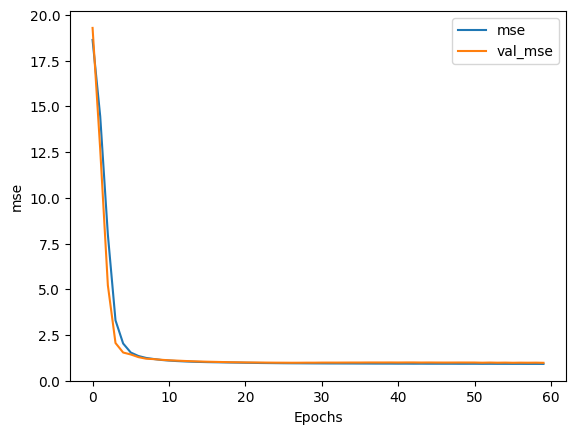

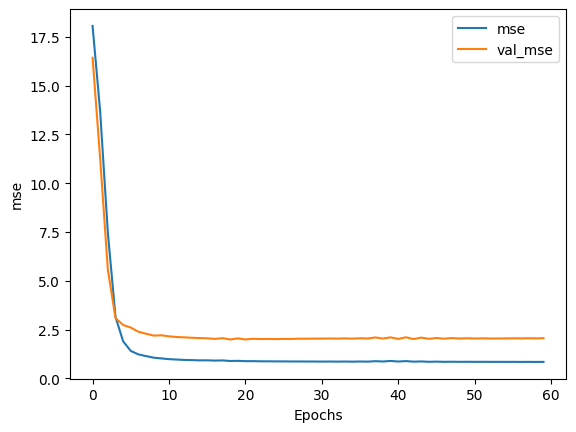

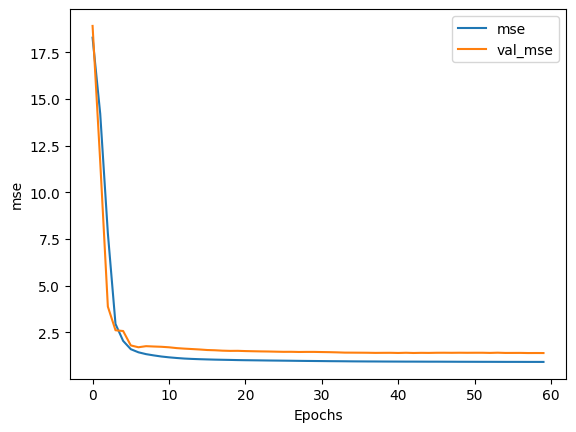

In [28]:
for history in histories[23],histories[38], histories[46]:
    plot_history(history, 'mse')

In [238]:
x_test_prediction = model.predict(x_test_scaled)
x_train_prediction = model.predict(x_train_scaled)
x_val_prediction = model.predict(x_val_scaled)
model.evaluate(x_test_scaled,y_test)



2/2 [==============================] - 0s 4ms/step - loss: 2.6694 - mse: 2.6694


[2.6694393157958984, 2.6694393157958984]

In [9]:
test_mse = model.evaluate(x_test_scaled,y_test)[0]

test_r2 = 1 - test_mse / np.var(y)
train_r2 = 1 - (history.history['mse'][-1]) / np.var(y)
validation_r2 = 1 - (history.history['val_mse'][-1] / np.var(y))
print(f"test_r2 = {test_r2}")
print(f"train_r2 = {train_r2}")
print(f"validation_r2 = {validation_r2}")

# old
# test_r2 = 0.05136689008017359
# train_r2 = 0.6860328224469545
# validation_r2 = 0.2578106429040692

#Old 
# 2/2 [==============================] - 0s 5ms/step - loss: 4.1783 - mse: 4.1783
# test_r2 = 0.33610127898858966
# train_r2 = 0.5598734298560093
# validation_r2 = 0.4182105838540471

2/2 [==============================] - 0s 4ms/step - loss: 2.6694 - mse: 2.6694
test_r2 = 0.2508969562829426
train_r2 = 0.7374710107293956
validation_r2 = 0.6686873068500084


In [240]:
table_actual_predicted = x_test.copy(deep=True)
table_actual_predicted['y_predicted'] = model.predict(x_test_scaled)
table_actual_predicted['y_true'] = y_test
table_actual_predicted.to_csv("18_testing_output_ann.csv",index=False )

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


line: y = 0.9445236787385952 * x + 0.2445596914271917


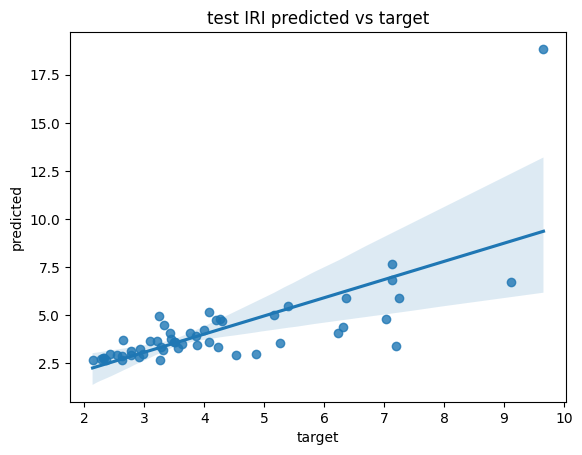

In [241]:
import seaborn as sns
ax = sns.regplot(x=y_test ,y= x_test_prediction,)
ax.set(title = 'test IRI predicted vs target', xlabel='target', ylabel='predicted')
#calculate slope and intercept of regression equation
import scipy
slope, intercept, r, p, sterr = scipy.stats.linregress(x=ax.get_lines()[0].get_xdata(),
                                                       y=ax.get_lines()[0].get_ydata())

print(f"line: y = {slope} * x + {intercept}")


line: y = 0.7445938391085829 * x + 1.0166621262525233


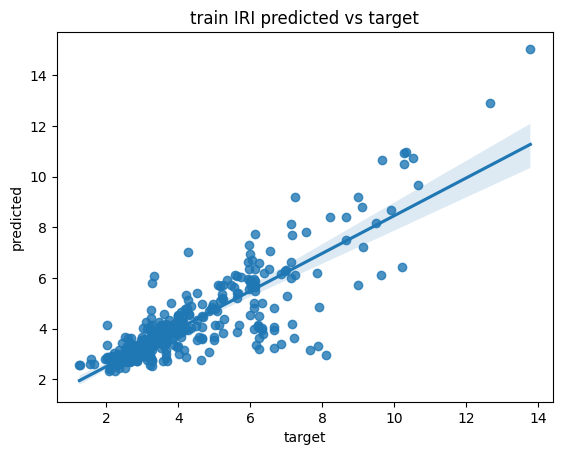

In [187]:
ax = sns.regplot(x=y_train, y= x_train_prediction)
ax.set(title = 'train IRI predicted vs target', xlabel='target', ylabel='predicted')

import scipy
slope, intercept, r, p, sterr = scipy.stats.linregress(x=ax.get_lines()[0].get_xdata(),
                                                       y=ax.get_lines()[0].get_ydata())

print(f"line: y = {slope} * x + {intercept}")



line: y = 0.8898533242307061 * x + 0.49419099024030455


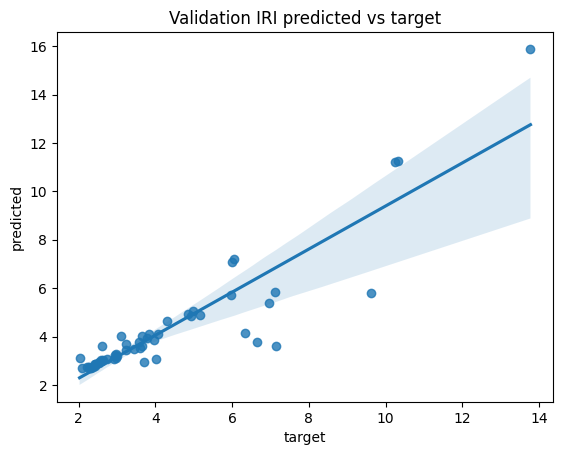

In [120]:
ax = sns.regplot(x=y_val, y= x_val_prediction)
ax.set(title = 'Validation IRI predicted vs target', xlabel='target', ylabel='predicted')

import scipy
slope, intercept, r, p, sterr = scipy.stats.linregress(x=ax.get_lines()[0].get_xdata(),
                                                       y=ax.get_lines()[0].get_ydata())

print(f"line: y = {slope} * x + {intercept}")

In [15]:
z = pd.DataFrame({'AC1': [ 0.26],
 'AC2': [ 1.2],
 'AC3': [ 0.12],
 'BE1': [ 0.151],
 'BE2': [ 0.0],
 'BE3': [ 0.0],
 'D1': [ 0.0],
 'D2': [ 0.0],
 'D3': [ 0.0],
 'F1': [ 0.0],
 'F2': [ 0.0],
 'F3': [ 0.0],
 'G1': [ 0.0],
 'G2': [ 0.0],
 'G3': [ 0.0],
 'H1': [ 0.0],
 'H2': [ 0.0],
 'H3': [ 0.0]})
model.predict(pd.DataFrame(z))


1/1 [==============================] - 0s 22ms/step


array([[4.482352]], dtype=float32)

In [32]:
# x_train = features, y_train = target
import pandas as pd

df = pd.read_csv('13-iri-cleaned.csv')



x = df.drop(['RoadRoidIRI'],axis=1)
y = df.RoadRoidIRI

import numpy as np
import os
import random
import tensorflow as tf

evaluation = []
histories = []
learning_rate = 0.01
# Seed value
# Apparently you may use different seed values at each stage
for initial_seed in [130]:
    seed_value= initial_seed

    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)
    # for later versions: 
    # tf.compat.v1.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    # import keras.backend.tensorflow_backend as K
    # session_conf =  tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    # K.set_session(sess)
    # for later versions:
    # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    # tf.compat.v1.keras.backend.set_session(sess)


    # from keras import backend as K
    # K.tensorflow_backend.set_session(sess)
    # import tensorflow.keras.backend as K
    # K.set_session(sess)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=seed_value)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8889, random_state=seed_value)


    x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)
    _ , x_val_scaled = scale_datasets(x_train, x_val)


    # model = build_model_using_sequential()
    for hu in [20]:
        model = Sequential([
            Dense(hu, kernel_initializer='normal', activation='relu'),
            # Dropout(0.2),
            # Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
            # Dropout(0.2),
            # Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
            Dense(1, kernel_initializer='normal', activation='relu')
        ])

        # loss function
        msle = MeanSquaredLogarithmicError()
        mse = MeanSquaredError()
        
        model.compile(
        loss=mse, 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=['mse' ]
    )
        # train the model
        history = model.fit(
            x_train_scaled.values, 
            y_train.values, 
            epochs=60, 
            batch_size=32,
            # validation_split=0.1,
            validation_data=(x_val_scaled.values, y_val.values),
            # verbose=0
        )

        # plot_history(history, 'mse')
        histories.append(history)


        test_mse = model.evaluate(x_test_scaled.values,y_test.values)[0]

        test_r2 = 1 - test_mse / np.var(y)
        train_r2 = 1 - (history.history['mse'][-1]) / np.var(y)
        validation_r2 = 1 - (history.history['val_mse'][-1] / np.var(y))

        r2_df.loc[(initial_seed, hu), :] = [train_r2, validation_r2, test_r2]
        evaluation.append([hu, test_r2, train_r2, validation_r2])
        
        print(f"test_r2 = {test_r2}")
        print(f"train_r2 = {train_r2}")
        print(f"validation_r2 = {validation_r2}")
r2_df.to_csv("eval3.csv")




Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 20.8115 - mse: 20.7862 - val_loss: 14.5195 - val_mse: 15.2114
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.9873 - mse: 14.0198 - val_loss: 4.0609 - val_mse: 4.2158
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3898 - mse: 4.4093 - val_loss: 3.2975 - val_mse: 3.4000
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3862 - mse: 2.4015 - val_loss: 1.6593 - val_mse: 1.7152
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7307 - mse: 1.7385 - val_loss: 1.2023 - val_mse: 1.2292
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6279 - mse: 1.6373 - val_loss: 1.3461 - val_mse: 1.3899
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5166 - mse: 1.5255 - val_loss: 1.2199 - val_mse: 1.2686
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4647 - mse: 1.4732 - val_loss: 1.1403 - val_mse: 1.1894
Epoch 9/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4239 